In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import shutil
from google.colab import files

Mounted at /content/drive/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import matplotlib.colors as colors
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, GlobalMaxPooling2D, Dense, Flatten, Dropout, MaxPooling2D, LSTM, Lambda
from keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import to_categorical

# **PRESSURE DATA**

In [ ]:
pressure_path = "/content/drive/MyDrive/First2YearRawAndNormData/CESMZ200/MinMaxNormWithLabel"
CL_path = pressure_path + "/CL"
COH_path = pressure_path + "/COH"
COL_path = pressure_path + "/COL"
NROI_path = pressure_path + "/NROI"


In [ ]:
CL_files = [f for f in os.listdir(CL_path) if f.endswith('.csv')]
COH_files = [f for f in os.listdir(COH_path) if f.endswith('.csv')]
COL_files = [f for f in os.listdir(COL_path) if f.endswith('.csv')]
NROI_files = [f for f in os.listdir(NROI_path) if f.endswith('.csv')]


In [ ]:
array = []
for file in CL_files:
    dataframe = pd.read_csv(os.path.join(CL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)

for file in COH_files:
    dataframe = pd.read_csv(os.path.join(COH_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)

for file in COL_files:
    dataframe = pd.read_csv(os.path.join(COL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)

for file in NROI_files:
    dataframe = pd.read_csv(os.path.join(NROI_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    array.append(dataframe)


In [ ]:
pressure_df = array
pressure_df = pd.DataFrame(pressure_df)
pressure_df.info()
Y = []
for i in range(len(CL_files)):
  Y.append(0)

for i in range(len(COH_files)):
  Y.append(1)

for i in range(len(COL_files)):
  Y.append(2)

for i in range(len(NROI_files)):
  Y.append(3)

Y = pd.DataFrame(Y)

scaler = StandardScaler()
X = scaler.fit_transform(pressure_df)

#print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Columns: 225 entries, 0 to 224
dtypes: float64(225)
memory usage: 1.3 MB


# **K-means For Pressure**

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state = 42, init = "k-means++", n_init = 30)
kmeans.fit(X)
labels = kmeans.labels_

cm = confusion_matrix(Y, labels)
accuracy_score(Y, labels)

0.3894165535956581

In [ ]:
cm

array([[ 83,   0,  92,   3],
       [  4,  97,  14,  46],
       [  7,  85, 103, 132],
       [  0,  67,   0,   4]])

[[ 4.36553026e+00 -1.59021884e-01 -4.98560861e-02 ...  1.49848998e-04
   5.97664131e-06 -1.10210505e-04]
 [ 6.37976562e+00 -1.31273872e-02 -1.58760901e-02 ... -7.87241683e-06
   1.03110210e-04  1.08660538e-04]
 [ 4.47250985e+00 -3.00987085e-01 -3.76158950e-01 ...  4.94656175e-05
   1.29898354e-04  1.11610454e-04]
 ...
 [-4.33605673e+00 -4.89624263e-03  1.43740314e-02 ... -1.83889673e-04
  -3.22388337e-04  1.40688511e-04]
 [-4.42710492e+00 -2.41340680e-02 -4.83963539e-02 ...  4.50719373e-05
   7.63084718e-05  9.42093783e-05]
 [-4.62343021e+00 -9.67443224e-02 -7.14637959e-02 ...  1.25007381e-04
   2.56087609e-06 -2.90183600e-04]]


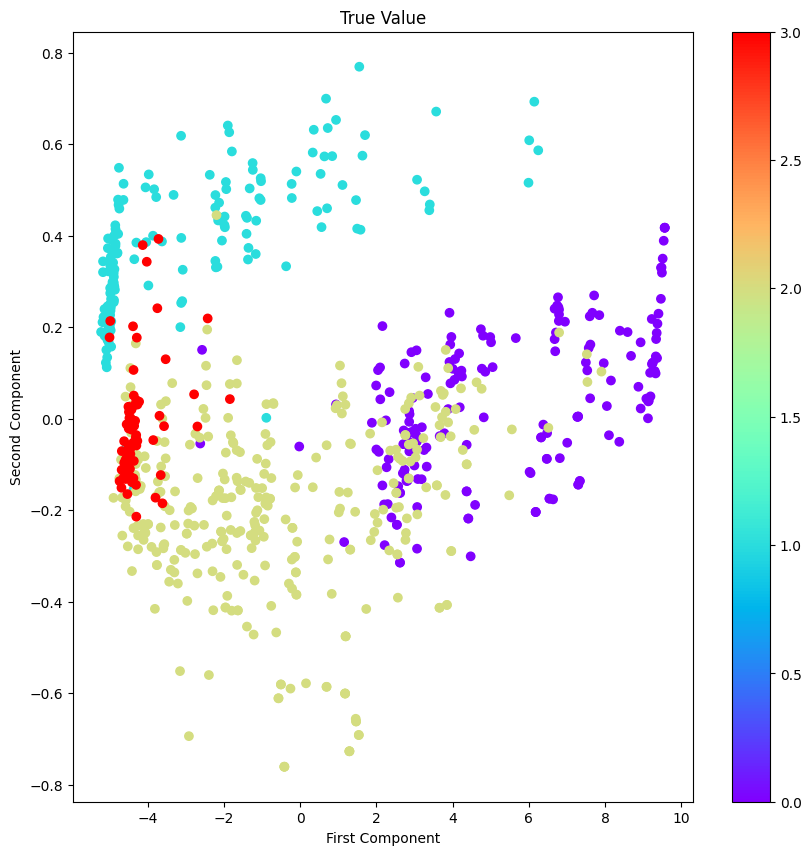

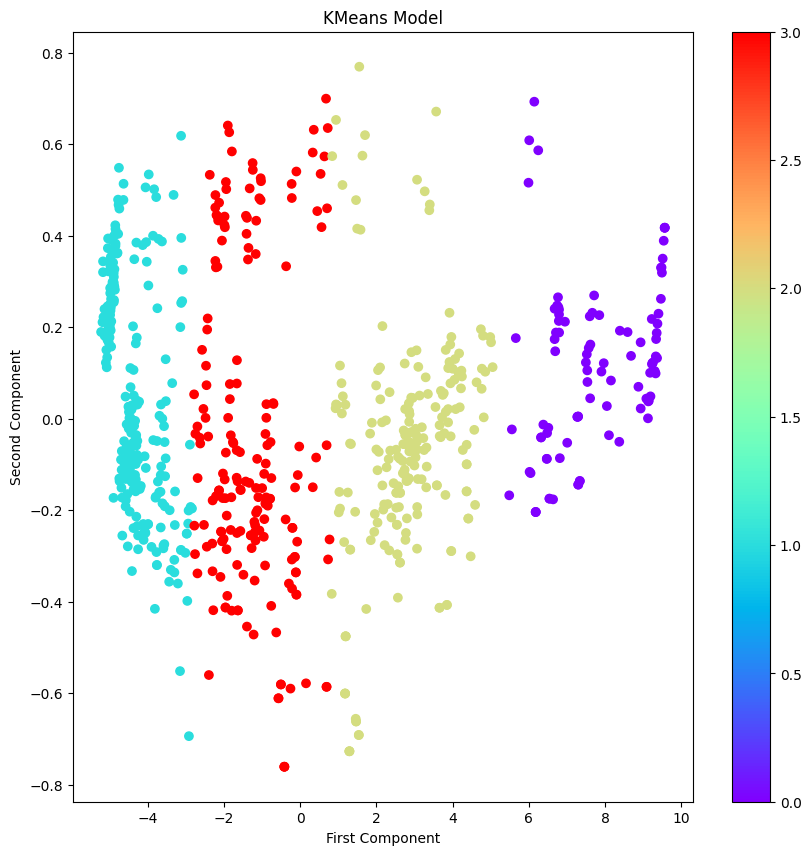

In [ ]:
pca = PCA(n_components=225)
principalComponents = pca.fit_transform(pressure_df)
print(principalComponents)


fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c = Y, cmap='rainbow')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('True Value')
plt.colorbar(scatter)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], c = labels, cmap='rainbow')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('KMeans Model')
plt.colorbar(scatter)
plt.show()

# **SOM For Pressure**

In [ ]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled

#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range


In [ ]:
num_rows = 15
num_cols = 15
max_m_dsitance = 10
max_learning_rate = 0.75
max_steps = 100000

In [ ]:
#main function

train_x_norm = minmax_scaler(X) # normalisation
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
#np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

In [ ]:
label_data = np.array(Y)
map = np.empty(shape=(num_rows, num_cols), dtype=object)


for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  #print(winner)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

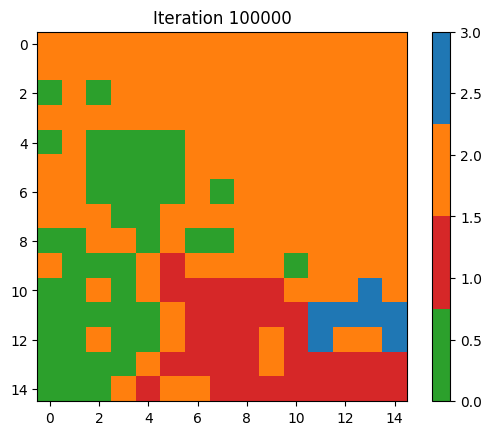

In [ ]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 2
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange', 'tab:blue'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [ ]:

# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data = minmax_scaler(X) # normalisation

winner_labels = []

for t in range(data.shape[0]):
 winner = winning_neuron(data, t, som, num_rows, num_cols)
 row = winner[0]
 col = winner[1]
 predicted = label_map[row][col]
 winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(Y, np.array(winner_labels)))

Accuracy:  0.8955223880597015


In [ ]:
cm = confusion_matrix(Y, np.array(winner_labels))
cm

array([[169,   0,   9,   0],
       [  0, 159,   1,   1],
       [ 21,   3, 288,  15],
       [  0,   7,  20,  44]])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(pressure_df, Y, test_size = 0.2, random_state = 42, shuffle = True)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(589, 225) (589, 1) (148, 225) (148, 1)


In [ ]:
#Reshape training and testing data
train_X = X_train.to_numpy().reshape(X_train.shape[0],15,15,1).astype("float32")

train_Y = Y_train.to_numpy()

test_X = X_test.to_numpy().reshape(X_test.shape[0],15,15,1).astype("float32")

test_Y = Y_test.to_numpy()

train_Y = to_categorical(train_Y, num_classes=4)
test_Y = to_categorical(test_Y, num_classes=4)

print(train_X.shape)

(589, 15, 15, 1)


# **CNN For Pressure**

In [ ]:
#Define the model architecture
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, activation = "relu", input_shape = (15, 15, 1)))
model.add(Conv2D(filters = 64, kernel_size = 3, activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 128, kernel_size = 3, activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(4, activation = "softmax"))

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=30)
tensorboard_callback = TensorBoard(log_dir="./logs")

# Fit the model
model.fit(train_X, train_Y, epochs=1000, batch_size=32, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/1000
19/19 [==============================] - 2s 25ms/step - loss: 1.2996 - accuracy: 0.3837
Epoch 2/1000
19/19 [==============================] - 0s 25ms/step - loss: 1.2212 - accuracy: 0.5229
Epoch 3/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.0238 - accuracy: 0.5857
Epoch 4/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.9482 - accuracy: 0.5620
Epoch 5/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.8785 - accuracy: 0.6163
Epoch 6/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.8815 - accuracy: 0.5925
Epoch 7/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.8679 - accuracy: 0.5908
Epoch 8/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.8758 - accuracy: 0.5891
Epoch 9/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.8341 - accuracy: 0.5993
Epoch 10/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.8460 - accura

In [ ]:
y_pred = model.predict(test_X).argmax(axis=1)
y_true_value = np.argmax(test_Y, axis = 1) #to change to one dimension 

accuracy = accuracy_score(y_true_value, y_pred)
print('Test accuracy:', accuracy)

5/5 [==============================] - 0s 15ms/step
Test accuracy: 0.8918918918918919


In [ ]:
conf_matrix = confusion_matrix(y_true_value, y_pred)
print(conf_matrix)

[[34  0  4  0]
 [ 0 32  0  0]
 [ 2  0 59  4]
 [ 0  1  5  7]]


# **RNN for Pressure**


In [ ]:
#Define the model architecture
model_rnn = Sequential()
model_rnn.add(LSTM(16, input_shape=(15,15), return_sequences=True))
model_rnn.add(Dropout(0.1))
model_rnn.add(LSTM(16, return_sequences=True))
model_rnn.add(Dropout(0.1))
model_rnn.add(LSTM(16))
model_rnn.add(Dense(4, activation='softmax'))

In [ ]:
model_rnn.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=30)


#Fit the model
model_rnn.fit(train_X, train_Y, epochs = 1000, batch_size = 16, verbose = 2, callbacks = early_stopping)

Epoch 1/1000
37/37 - 8s - loss: 1.2752 - accuracy: 0.4397 - 8s/epoch - 205ms/step
Epoch 2/1000
37/37 - 1s - loss: 1.0859 - accuracy: 0.5093 - 1s/epoch - 30ms/step
Epoch 3/1000
37/37 - 1s - loss: 0.9483 - accuracy: 0.5603 - 1s/epoch - 30ms/step
Epoch 4/1000
37/37 - 1s - loss: 0.9134 - accuracy: 0.5840 - 934ms/epoch - 25ms/step
Epoch 5/1000
37/37 - 1s - loss: 0.9202 - accuracy: 0.5823 - 775ms/epoch - 21ms/step
Epoch 6/1000
37/37 - 1s - loss: 0.8898 - accuracy: 0.6078 - 780ms/epoch - 21ms/step
Epoch 7/1000
37/37 - 1s - loss: 0.8656 - accuracy: 0.5942 - 800ms/epoch - 22ms/step
Epoch 8/1000
37/37 - 1s - loss: 0.8743 - accuracy: 0.6112 - 810ms/epoch - 22ms/step
Epoch 9/1000
37/37 - 1s - loss: 0.8344 - accuracy: 0.6248 - 819ms/epoch - 22ms/step
Epoch 10/1000
37/37 - 1s - loss: 0.8505 - accuracy: 0.5925 - 816ms/epoch - 22ms/step
Epoch 11/1000
37/37 - 1s - loss: 0.8291 - accuracy: 0.6129 - 795ms/epoch - 21ms/step
Epoch 12/1000
37/37 - 1s - loss: 0.8176 - accuracy: 0.6129 - 804ms/epoch - 22ms/st

In [ ]:
# predict class probabilities for test set
Y_pred1 = model_rnn.predict(test_X)

# convert predicted probabilities to class labels
Y_pred_labels1 = np.argmax(Y_pred1, axis=1)


# convert true labels to class labels
Y_true_labels = np.argmax(test_Y, axis=1)

#Accuracy
accuracy = accuracy_score(Y_true_labels, Y_pred_labels1)
print(accuracy)

# compute confusion matrix
conf_matrix1 = confusion_matrix(Y_true_labels, Y_pred_labels1)

print(conf_matrix1)

5/5 [==============================] - 3s 15ms/step
0.8986486486486487
[[36  0  2  0]
 [ 0 32  0  0]
 [ 3  0 56  6]
 [ 0  0  4  9]]


# **WIND AND PRESSURE DATA**


In [ ]:
wind_path = "/content/drive/MyDrive/First2YearRawAndNormData/CESMU200/MinMaxNormWithLabel"
wind_CL_path = wind_path + "/CL"
wind_COH_path = wind_path + "/COH"
wind_COL_path = wind_path + "/COL"
wind_NROI_path = wind_path + "/NROI"

In [ ]:
CL_wind_files = [f for f in os.listdir(wind_CL_path) if f.endswith(".csv")]
COH_wind_files = [f for f in os.listdir(wind_COH_path) if f.endswith(".csv")]
COL_wind_files = [f for f in os.listdir(wind_COL_path) if f.endswith(".csv")]
NROI_wind_files = [f for f in os.listdir(wind_NROI_path) if f.endswith(".csv")]

In [ ]:
wind_array = []
for file in CL_wind_files:
    dataframe = pd.read_csv(os.path.join(CL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    wind_array.append(dataframe)

for file in COH_wind_files:
    dataframe = pd.read_csv(os.path.join(COH_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    wind_array.append(dataframe)

for file in COL_wind_files:
    dataframe = pd.read_csv(os.path.join(COL_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    wind_array.append(dataframe)

for file in NROI_wind_files:
    dataframe = pd.read_csv(os.path.join(NROI_path, file), header=None)
    dataframe = dataframe.to_numpy().flatten()
    wind_array.append(dataframe)


In [ ]:
wind_df = wind_array
wind_df = pd.DataFrame(wind_df)
wind_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Columns: 225 entries, 0 to 224
dtypes: float64(225)
memory usage: 1.3 MB


In [ ]:
#Combine the data
df_array = np.stack((np.array(pressure_df), np.array(wind_df)), axis = 2)

#Reshape the data
(h, w, c) = df_array.shape
reshape_df_array = df_array.reshape(h, w*c)
print(reshape_df_array.shape)

(737, 450)


In [ ]:
n_kmeans = KMeans(n_clusters = 4, random_state = 42)
n_kmeans.fit(reshape_df_array)
n_labels = n_kmeans.labels_

n_cm = confusion_matrix(Y, n_labels)
n_cm

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[  0,  65, 111,   2],
       [114,  18,   0,  29],
       [119, 105,   5,  98],
       [ 71,   0,   0,   0]])

# **SOM For Combined data**

In [ ]:
n_num_rows = 15
n_num_cols = 15
n_max_m_dsitance = 10
n_max_learning_rate = 0.75
n_max_steps = 30000

In [ ]:
#main function

n_train_x_norm = minmax_scaler(reshape_df_array) # normalisation
# initialising self-organising map
num_dims = n_train_x_norm.shape[1] # numnber of dimensions in the input data
#np.random.seed(40)
som = np.random.random_sample(size=(n_num_rows, n_num_cols, num_dims)) # map construction

# start training iterations
for step in range(n_max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, n_max_steps,n_max_learning_rate,n_max_m_dsitance)

  t = np.random.randint(0,high=n_train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(n_train_x_norm, t, som, n_num_rows, n_num_cols)
  for row in range(n_num_rows):
    for col in range(n_num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(n_train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
SOM training completed


In [ ]:
label_data = np.array(Y)
map = np.empty(shape=(n_num_rows, n_num_cols), dtype=object)


for row in range(n_num_rows):
  for col in range(n_num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(n_train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(n_train_x_norm, t, som, n_num_rows, n_num_cols)
  #print(winner)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

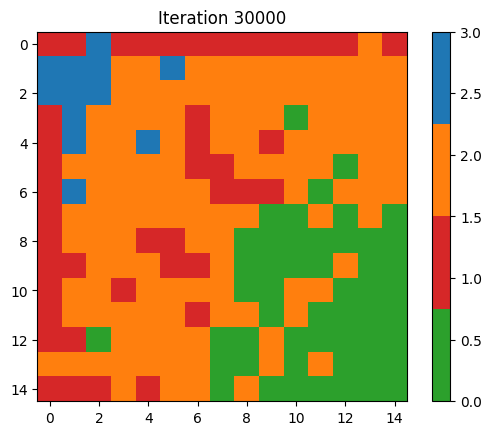

In [ ]:
# construct label map
label_map = np.zeros(shape=(n_num_rows, n_num_cols),dtype=np.int64)
for row in range(n_num_rows):
  for col in range(n_num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 2
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(n_max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange', 'tab:blue'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [ ]:
# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data = minmax_scaler(reshape_df_array) # normalisation

n_winner_labels = []

for t in range(data.shape[0]):
 winner = winning_neuron(data, t, som, num_rows, num_cols)
 row = winner[0]
 col = winner[1]
 predicted = label_map[row][col]
 n_winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(Y, np.array(n_winner_labels)))

Accuracy:  0.8846675712347354


In [ ]:
n_cm = confusion_matrix(Y, np.array(n_winner_labels))
print(n_cm)

[[174   0   4   0]
 [  2 147  12   0]
 [ 17  17 275  18]
 [  0   4  11  56]]


In [ ]:
#Split the data into train and test
df_train, df_test, labels_train, labels_test = train_test_split(df_array, Y, test_size = 0.2, random_state = 42, shuffle = True)
print(df_train.shape, labels_train.shape, df_test.shape, labels_test.shape)

(589, 225, 2) (589, 1) (148, 225, 2) (148, 1)


In [ ]:
#Reshape training and testing data
df_train = df_train.reshape(df_train.shape[0], 15, 15, 2)
df_test = df_test.reshape(df_test.shape[0], 15, 15, 2)

labels_train = to_categorical(labels_train, num_classes = 4)
labels_test = to_categorical(labels_test, num_classes = 4)

# **CNN For Combined Data**

In [ ]:
#Define the model architecture
n_cnn_model = Sequential()
n_cnn_model.add(Conv2D(filters = 32, kernel_size = 3, activation = "relu", input_shape = (15, 15, 2)))
n_cnn_model.add(Conv2D(filters = 64, kernel_size = 3, activation = "relu"))
n_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
n_cnn_model.add(Conv2D(filters = 128, kernel_size = 3, activation = "relu"))
n_cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
n_cnn_model.add(Flatten())
n_cnn_model.add(Dense(128, activation = "relu"))
n_cnn_model.add(Dense(64, activation = "relu"))
n_cnn_model.add(Dense(4, activation = "softmax"))

In [ ]:
# Compile the model
n_cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=30)
tensorboard_callback = TensorBoard(log_dir="./logs")

# Fit the model
n_cnn_model.fit(df_train, labels_train, epochs=1000, batch_size=32, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/1000
19/19 [==============================] - 3s 44ms/step - loss: 1.2746 - accuracy: 0.4363
Epoch 2/1000
19/19 [==============================] - 1s 42ms/step - loss: 1.1862 - accuracy: 0.4839
Epoch 3/1000
19/19 [==============================] - 1s 41ms/step - loss: 0.9992 - accuracy: 0.5671
Epoch 4/1000
19/19 [==============================] - 1s 44ms/step - loss: 0.8906 - accuracy: 0.5874
Epoch 5/1000
19/19 [==============================] - 1s 38ms/step - loss: 0.7696 - accuracy: 0.6520
Epoch 6/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.8260 - accuracy: 0.6078
Epoch 7/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.7524 - accuracy: 0.6486
Epoch 8/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.7129 - accuracy: 0.6757
Epoch 9/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.7027 - accuracy: 0.6774
Epoch 10/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.6837 - accura

In [ ]:
n_y_cnn_pred = n_cnn_model.predict(df_test).argmax(axis=1)
n_y_true_value = np.argmax(labels_test, axis = 1) #to change to one dimension 

accuracy = accuracy_score(n_y_true_value, n_y_cnn_pred)
print('Test accuracy:', accuracy)

5/5 [==============================] - 0s 7ms/step
Test accuracy: 0.9391891891891891


In [ ]:
n_cnn_conf_matrix = confusion_matrix(n_y_true_value, n_y_cnn_pred)
print(n_cnn_conf_matrix)

[[38  0  0  0]
 [ 0 31  0  1]
 [ 3  0 59  3]
 [ 0  1  1 11]]


# **RNN For Combined Data**

In [ ]:
#Define the model architecture
n_model_rnn = Sequential()
n_model_rnn.add(Lambda(lambda x: x[:,:,:,0], input_shape = (15,15,2)))
n_model_rnn.add(LSTM(64, return_sequences=True))
n_model_rnn.add(Dropout(0.1))
n_model_rnn.add(LSTM(64, return_sequences=True))
n_model_rnn.add(Dropout(0.1))
n_model_rnn.add(LSTM(64))
n_model_rnn.add(Dense(4, activation='softmax'))

In [ ]:
n_model_rnn.compile(loss =  "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
early_stopping = EarlyStopping(monitor = "loss", patience = 30)

#Fit the model
n_model_rnn.fit(df_train, labels_train, epochs = 1000, batch_size = 64, verbose = 2, callbacks = early_stopping)

Epoch 1/1000
10/10 - 7s - loss: 1.2701 - accuracy: 0.4075 - 7s/epoch - 719ms/step
Epoch 2/1000
10/10 - 0s - loss: 1.1264 - accuracy: 0.5229 - 393ms/epoch - 39ms/step
Epoch 3/1000
10/10 - 0s - loss: 0.9483 - accuracy: 0.5739 - 384ms/epoch - 38ms/step
Epoch 4/1000
10/10 - 0s - loss: 0.9225 - accuracy: 0.5603 - 390ms/epoch - 39ms/step
Epoch 5/1000
10/10 - 0s - loss: 0.9121 - accuracy: 0.5603 - 400ms/epoch - 40ms/step
Epoch 6/1000
10/10 - 0s - loss: 0.9145 - accuracy: 0.5637 - 418ms/epoch - 42ms/step
Epoch 7/1000
10/10 - 0s - loss: 0.8799 - accuracy: 0.5552 - 439ms/epoch - 44ms/step
Epoch 8/1000
10/10 - 0s - loss: 0.8701 - accuracy: 0.5688 - 400ms/epoch - 40ms/step
Epoch 9/1000
10/10 - 0s - loss: 0.8590 - accuracy: 0.5908 - 388ms/epoch - 39ms/step
Epoch 10/1000
10/10 - 0s - loss: 0.8535 - accuracy: 0.6095 - 383ms/epoch - 38ms/step
Epoch 11/1000
10/10 - 0s - loss: 0.8874 - accuracy: 0.5739 - 403ms/epoch - 40ms/step
Epoch 12/1000
10/10 - 0s - loss: 0.8666 - accuracy: 0.5959 - 370ms/epoch - 3

In [ ]:
## predict class probabilities for test set
n_Y_pred_rnn = n_model_rnn.predict(df_test)

# convert predicted probabilities to class labels
n_labels_rnn = np.argmax(n_Y_pred_rnn, axis=1)


# convert true labels to class labels
Y_true_labels = np.argmax(test_Y, axis=1)

#Accuracy
accuracy = accuracy_score(Y_true_labels, n_labels_rnn)
print(accuracy)

# compute confusion matrix
conf_matrix1 = confusion_matrix(Y_true_labels, n_labels_rnn)

print(conf_matrix1)

5/5 [==============================] - 1s 10ms/step


NameError: ignored

In [ ]:
print(X)

[[-0.87465872 -0.89239983 -0.90739011 ... -0.86674022 -0.88372151
  -0.90238218]
 [-1.36998307 -1.38217184 -1.3944502  ... -1.51495806 -1.54396323
  -1.57593743]
 [-0.74668375 -0.75818317 -0.76923248 ... -1.06142703 -1.06156184
  -1.06573651]
 ...
 [ 0.83882325  0.88067051  0.9214292  ...  1.01596323  1.00586184
   0.99297965]
 [ 1.12795887  1.11613606  1.11344123 ...  1.01153772  1.00364019
   0.99745596]
 [ 1.14928675  1.15616726  1.1696434  ...  1.0447237   1.03920826
   1.02654651]]


In [ ]:
import numpy as np
import plotly.graph_objects as go



# Create a surface plot using Plotly
fig = go.Figure(data=[go.Surface(z=data)])
fig.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Create a box plot using Plotly
fig = go.Figure(data=[go.Box(y=data)])
fig.show()

In [ ]:
pressure_df["Class"] = Y
pressure_df.head()

0         1         2         3         4         5         6  \
0  0.475692  0.473846  0.471385  0.468923  0.465846  0.462769  0.460308   
1  0.464615  0.463385  0.462769  0.460923  0.460308  0.457846  0.455385   
2  0.248615  0.243692  0.240000  0.237538  0.235692  0.234462  0.234462   
3  0.552000  0.544000  0.536615  0.529846  0.524923  0.521846  0.520000   
4  0.248615  0.243692  0.240000  0.237538  0.235692  0.234462  0.234462   

          7         8         9  ...       216       217       218       219  \
0  0.456615  0.453538  0.450462  ...  0.425846  0.424000  0.422769  0.422154   
1  0.452923  0.451077  0.450462  ...  0.429538  0.418462  0.412923  0.411077   
2  0.235692  0.237538  0.240615  ...  0.228308  0.220308  0.216000  0.214154   
3  0.519385  0.520615  0.523077  ...  0.460923  0.451077  0.444923  0.443077   
4  0.235692  0.237538  0.240615  ...  0.228308  0.220308  0.216000  0.214154   

        220       221       222       223       224  Class  
0  0.423385  0.425846  0.429538  0.435077  0.443077      0  
1  0.414769  0.424000  0.437538  0.454769  0.475077      0  
2  0.216615  0.222769  0.232615  0.246154  0.264615      0  
3  0.444923  0.451077  0.461538  0.475077  0.492923      0  
4  0.216615  0.222769  0.232615  0.246154  0.264615      0  

[5 rows x 226 columns]

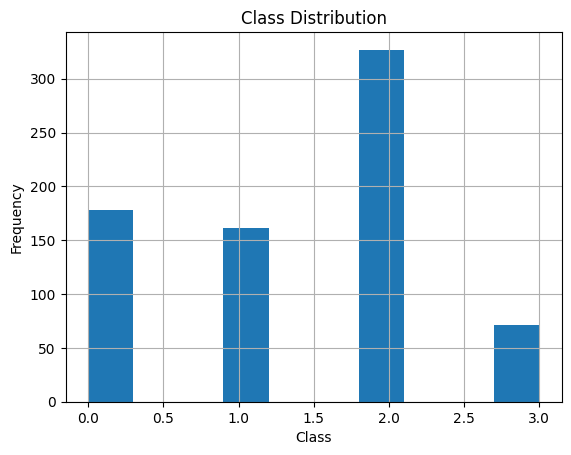

In [ ]:
pressure_df.hist(column = "Class")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution")

plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go



# Create a surface plot using Plotly
fig1 = go.Figure(data=[go.Surface(z=wind_df)])
fig1.show()


In [ ]:
print(fig1==fig)

False


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Create a box plot using Plotly
fig = go.Figure(data=[go.Box(y=wind_df)])
fig.show()